In [187]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from data_cleanup import *
from feature_selection import *
from model_ import *
from country_evaluation import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'wbgi_cce']
meta_cols = ['ccode', 'ccode_qog', 'ccodealp', 'ccodealp_year', 'ccodecow', 'cname', 'cname_qog', 'cname_year', 'version', 'year', 'region', 'sub-region']
df = load_reduced_df(corr_cols)

In [3]:
display(df.shape)

(2836, 2528)

### Feature selection

In [4]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}

for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, corr_cols = corr_cols, meta_cols=meta_cols, target_col=target_col)
    
    best_features = pre_select(X_train, y_train)
    best_features_dict[target_col] = set(best_features)
    df_train = X_train[best_features].copy()
    df_train[target_col]=y_train
    mce = MultiCollinearityEliminator(df_train, target_col, 0.85)
    feaures_no_collinearity = list(mce.autoEliminateMulticollinearity().columns)
    feaures_no_collinearity.remove(target_col)
    selected_features_dict[target_col] = set(feaures_no_collinearity)


#selected_features_dict

In [5]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

print(df[best_features_union].isna().sum().sort_values(ascending=False))


cpds_vnl_nan         0
cpds_lper_0.0        0
cpds_vpen_0.0        0
br_mon               0
fh_pr_1.0            0
cpds_lall_0.0        0
ihme_hle_0104m       0
cpds_chg_0.0         0
ihme_hle_0104t       0
fh_cl_1.0            0
kun_cluster_5.0      0
cpds_govlr_nan       0
cpds_vnl_0.0         0
fh_status_1.0        0
ihme_lifexp_0104m    0
ihme_hle_0104f       0
ciri_injud_2.0       0
wel_scalezone_4.0    0
cpds_lper_nan        0
cpds_vper_0.0        0
cpds_tg_nan          0
cpds_lpen_0.0        0
cpds_lall_nan        0
ihme_lifexp_0104t    0
cpds_vper_nan        0
cpds_vpen_nan        0
bmr_dem              0
bmr_demfsuf          0
fh_ipolity2          0
wel_sys_1.0          0
cpds_lpen_nan        0
fhp_status5_1.0      0
gd_ptss_1.0          0
ihme_lifexp_0104f    0
cpds_chg_nan         0
dtype: int64


In [6]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['cpds_vper_0.0',
 'fh_status_1.0',
 'fhp_status5_1.0',
 'gd_ptss_1.0',
 'fh_cl_1.0']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [50]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.627212,9.612732
bci_bci,0.444338,9.774873
ti_cpi_om,0.637552,1.045133
wbgi_cce,0.636847,0.50599


feature importance


,fh_status_1.0,fhp_status5_1.0,gd_ptss_1.0,cpds_vper_0.0,fh_cl_1.0,cpds_lall_0.0,cpds_chg_0.0,fh_ipolity2,ihme_lifexp_0104t,fh_pr_1.0,br_mon,kun_cluster_5.0,wel_sys_1.0,ihme_lifexp_0104m,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,0.094037,0.043534,0.216709,0.00736,0.292106,0.016842,0.0,0.082221,0.247192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bci_bci,0.0,0.003761,0.160328,0.0,0.165181,NaN,NaN,NaN,NaN,0.085449,0.215479,0.068628,0.0,0.225905,0.07527,NaN
ti_cpi_om,0.013824,0.0,0.12007,0.0,0.176867,NaN,NaN,NaN,NaN,0.05823,NaN,0.251078,NaN,0.217902,0.16203,0.0
wbgi_cce,0.092949,0.004959,0.17618,0.00974,0.194415,NaN,NaN,0.006165,0.215043,0.093125,NaN,0.116697,0.006076,NaN,0.084651,NaN



feature importance rank


,fh_status_1.0,fhp_status5_1.0,gd_ptss_1.0,cpds_vper_0.0,fh_cl_1.0,cpds_lall_0.0,cpds_chg_0.0,fh_ipolity2,ihme_lifexp_0104t,fh_pr_1.0,br_mon,kun_cluster_5.0,wel_sys_1.0,ihme_lifexp_0104m,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,4,6,3,8,1,7,<NA>,5,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
bci_bci,<NA>,8,4,<NA>,3,<NA>,<NA>,<NA>,<NA>,5,2,7,<NA>,1,6,<NA>
ti_cpi_om,7,<NA>,5,<NA>,3,<NA>,<NA>,<NA>,<NA>,6,<NA>,1,<NA>,2,4,<NA>
wbgi_cce,6,11,3,8,2,<NA>,<NA>,9,1,5,<NA>,4,10,<NA>,7,<NA>


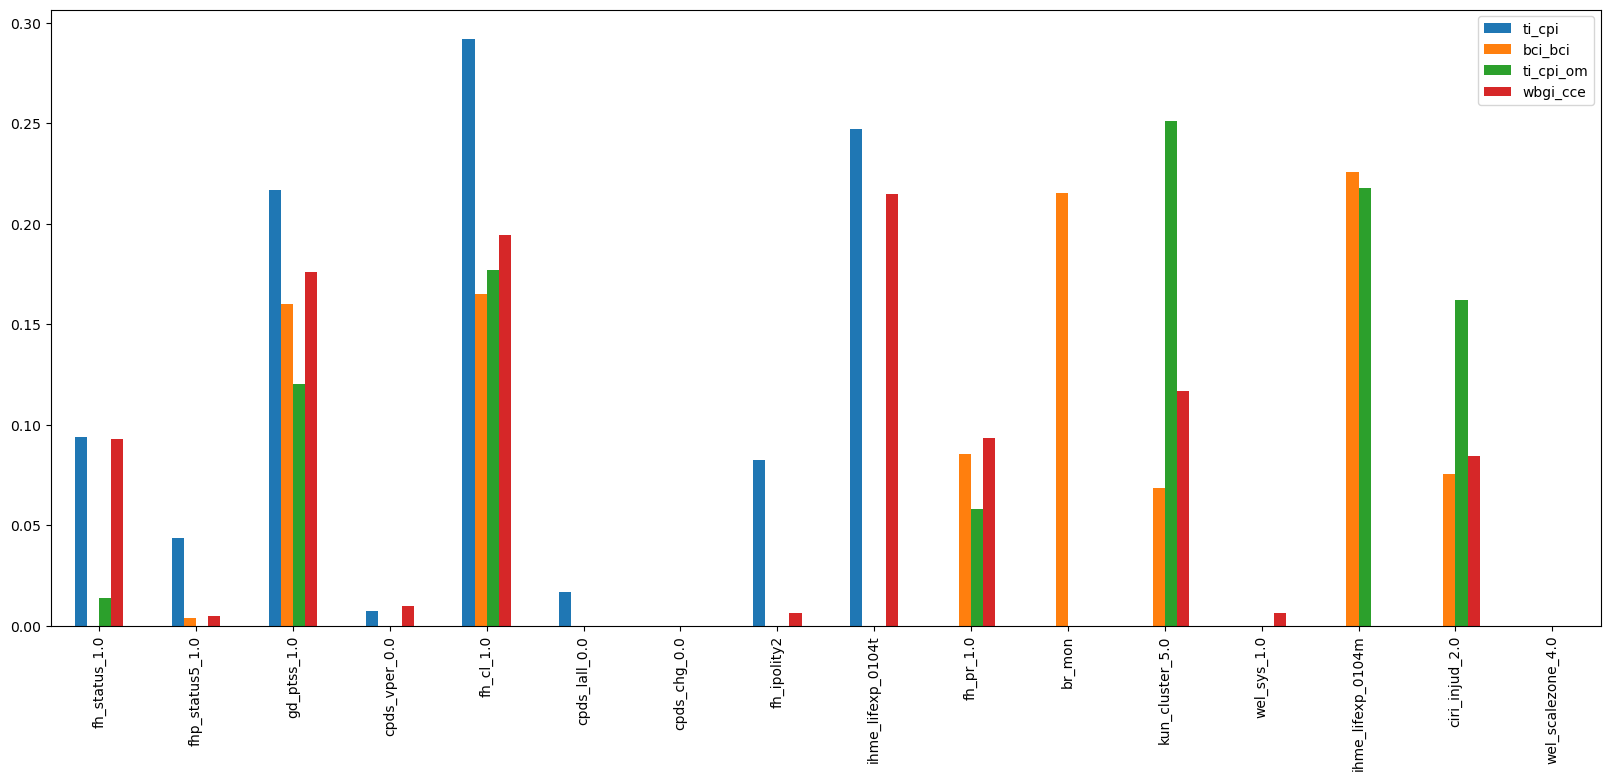

In [51]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.635065,9.510943
bci_bci,0.455413,9.676978
ti_cpi_om,0.666843,1.002013
wbgi_cce,0.636938,0.505927


feature importance


,cpds_govlr_nan,cpds_lpen_nan,br_mon,cpds_chg_nan,kun_cluster_5.0,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,wel_sys_1.0,...,ihme_lifexp_0104f,fh_pr_1.0,fh_status_1.0,cpds_lpen_0.0,gd_ptss_1.0,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan
ti_cpi,0.0,0.0,0.204742,0.0,0.0,0.0,0.049098,0.003199,0.0,0.012415,...,0.0,0.122019,0.055197,0.0,0.136602,0.0,0.0,0.0,0.0,0.0
bci_bci,0.0,0.0,0.187187,0.0,0.067964,0.0,0.0,0.008418,0.0,0.0,...,0.0,0.094846,0.0,0.0,0.144368,0.0,0.0,0.0,0.0,0.0
ti_cpi_om,0.0,0.0,0.102626,0.0,0.171602,0.0,0.0,0.003827,0.0,0.124687,...,0.0,0.010279,0.049225,0.0,0.084686,0.0,0.0,0.0,0.0,0.0
wbgi_cce,0.0,0.0,0.143257,0.0,0.06471,0.0,0.027603,0.0,0.0,0.033534,...,0.0,0.083141,0.078998,0.0,0.117116,0.0,0.0,0.0,0.0,0.0



feature importance rank


,cpds_govlr_nan,cpds_lpen_nan,br_mon,cpds_chg_nan,kun_cluster_5.0,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,wel_sys_1.0,...,ihme_lifexp_0104f,fh_pr_1.0,fh_status_1.0,cpds_lpen_0.0,gd_ptss_1.0,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan
ti_cpi,<NA>,<NA>,1,<NA>,<NA>,<NA>,8,11,<NA>,9,...,<NA>,4,7,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>
bci_bci,<NA>,<NA>,2,<NA>,7,<NA>,<NA>,11,<NA>,<NA>,...,<NA>,5,<NA>,<NA>,4,<NA>,<NA>,<NA>,<NA>,<NA>
ti_cpi_om,<NA>,<NA>,5,<NA>,1,<NA>,<NA>,12,<NA>,4,...,<NA>,11,8,<NA>,7,<NA>,<NA>,<NA>,<NA>,<NA>
wbgi_cce,<NA>,<NA>,2,<NA>,8,<NA>,12,<NA>,<NA>,11,...,<NA>,5,6,<NA>,4,<NA>,<NA>,<NA>,<NA>,<NA>


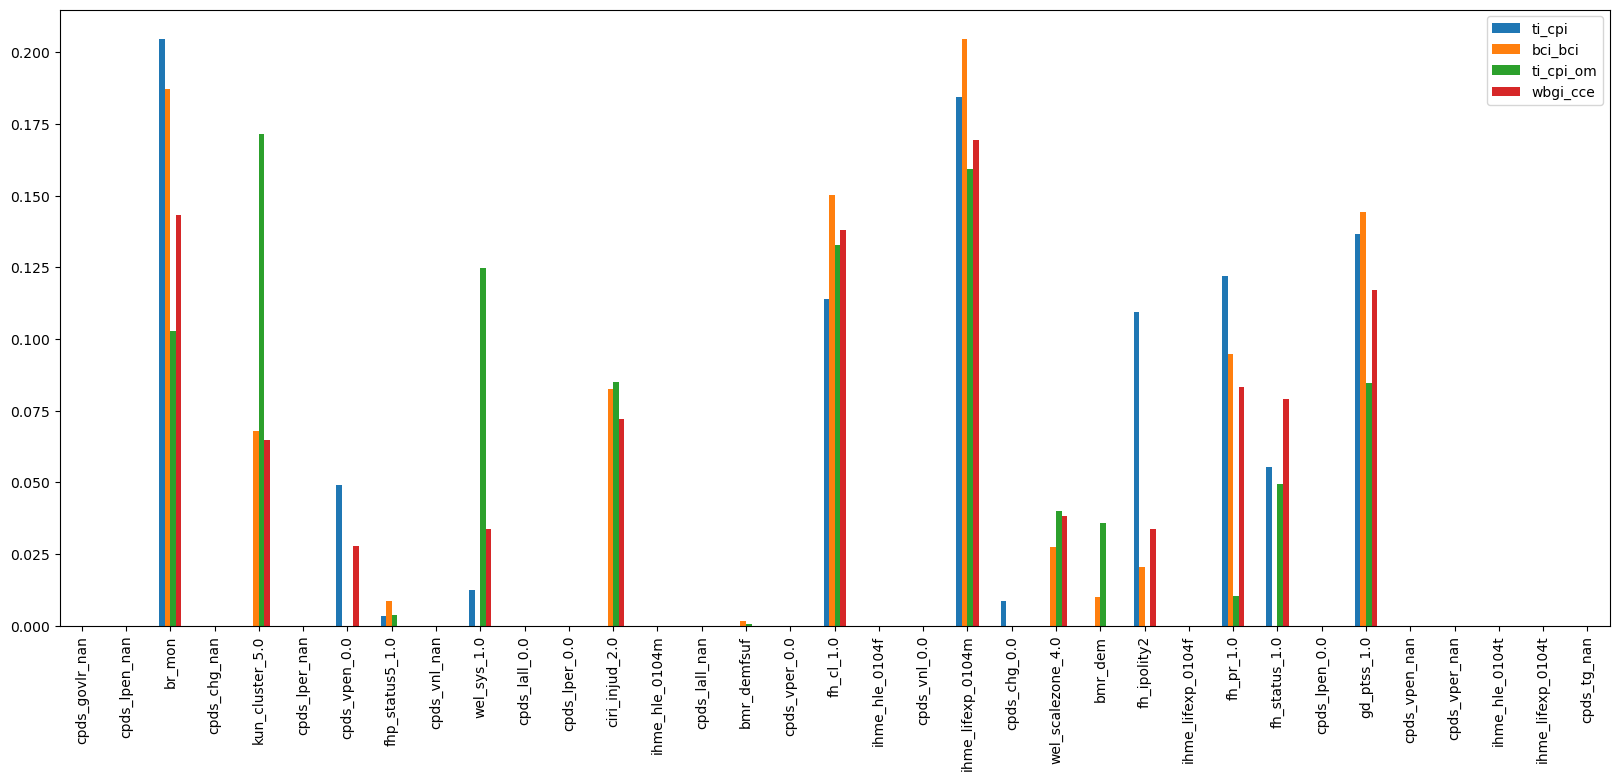

In [52]:
lasso_info_script(best_features_union)

In [53]:
df.dtypes[best_features_union]
df.br_mon.describe()

count    2836.000000
mean        0.190056
std         0.392415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: br_mon, dtype: float64

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.621747,9.682942
bci_bci,0.385986,10.275318
ti_cpi_om,0.637458,1.045268
wbgi_cce,0.650326,0.496511


feature importance


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,0.214512,0.261108,0.056023,0.094461,0.373896
bci_bci,0.024277,0.373185,0.093248,0.09673,0.41256
ti_cpi_om,0.123553,0.275037,0.0,0.192872,0.408538
wbgi_cce,0.201441,0.26157,0.048311,0.156115,0.332562



feature importance rank


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,3,2,5,4,1
bci_bci,5,2,4,3,1
ti_cpi_om,4,2,<NA>,3,1
wbgi_cce,3,2,5,4,1


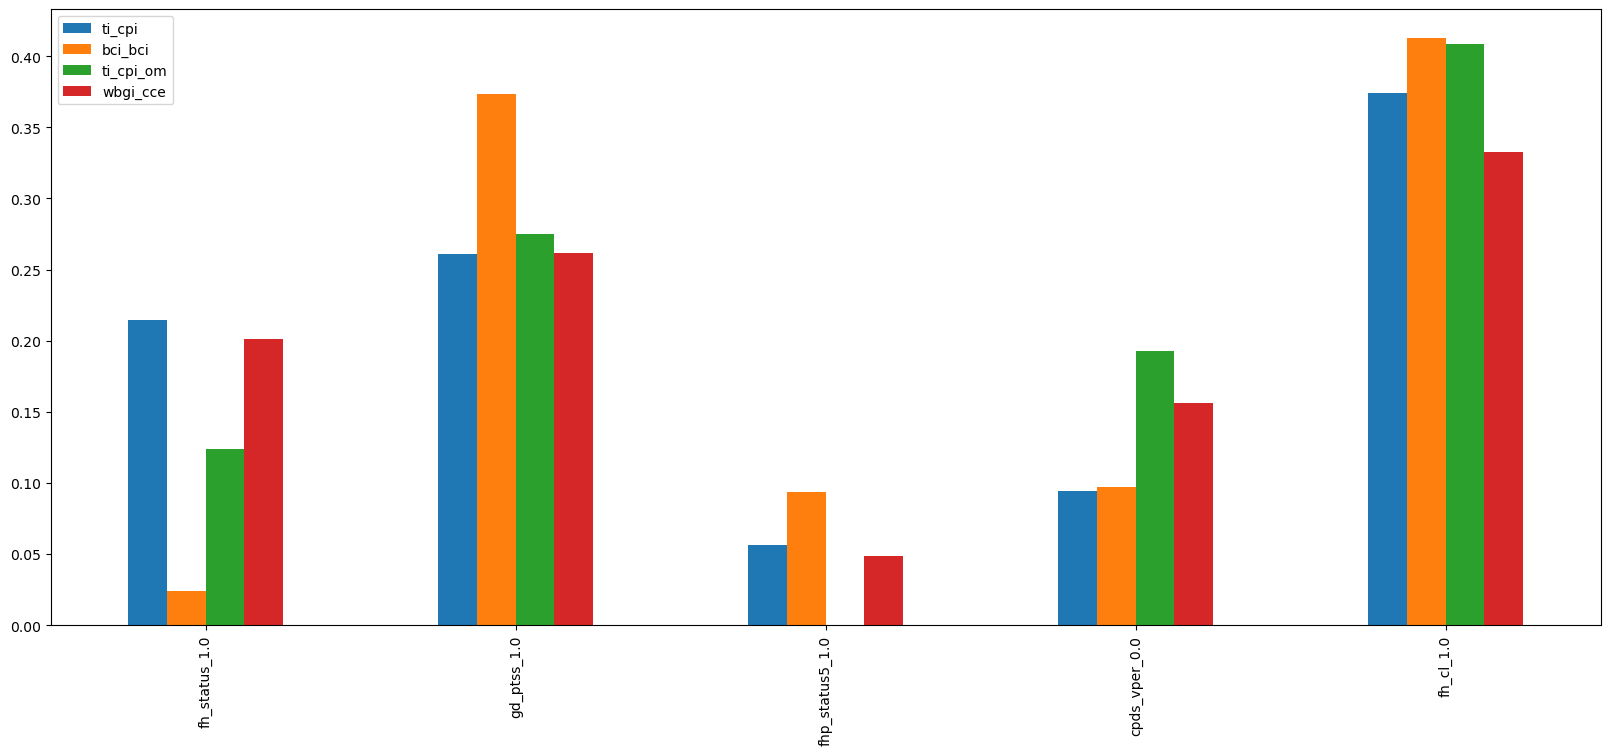

In [54]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [55]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



First we apply again the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.599852,9.959242
bci_bci,0.332077,10.716896
ti_cpi_om,0.675853,0.988371
wbgi_cce,0.527016,0.577458


feature importance


,fh_status_1.0,fhp_status5_1.0,gd_ptss_1.0,cpds_vper_0.0,fh_cl_1.0,cpds_lall_0.0,cpds_chg_0.0,fh_ipolity2,ihme_lifexp_0104t,fh_pr_1.0,br_mon,kun_cluster_5.0,wel_sys_1.0,ihme_lifexp_0104m,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,0.001654,0.004249,0.027163,0.002082,0.386984,0.002226,0.003572,0.315057,0.257014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bci_bci,0.013875,0.009004,0.024597,0.008187,0.287193,NaN,NaN,NaN,NaN,0.157638,0.102139,0.033667,0.008398,0.332631,0.022671,NaN
ti_cpi_om,0.011593,0.005126,0.027846,0.004639,0.205578,NaN,NaN,NaN,NaN,0.378535,NaN,0.112682,NaN,0.228431,0.0189,0.00667
wbgi_cce,0.002904,0.003628,0.032991,0.003867,0.005258,NaN,NaN,0.455826,0.197033,0.242739,NaN,0.037008,0.010767,NaN,0.007979,NaN



feature importance rank


,fh_status_1.0,fhp_status5_1.0,gd_ptss_1.0,cpds_vper_0.0,fh_cl_1.0,cpds_lall_0.0,cpds_chg_0.0,fh_ipolity2,ihme_lifexp_0104t,fh_pr_1.0,br_mon,kun_cluster_5.0,wel_sys_1.0,ihme_lifexp_0104m,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,9,5,4,8,1,7,6,2,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
bci_bci,8,9,6,11,2,<NA>,<NA>,<NA>,<NA>,3,4,5,10,1,7,<NA>
ti_cpi_om,7,9,5,10,3,<NA>,<NA>,<NA>,<NA>,1,<NA>,4,<NA>,2,6,8
wbgi_cce,11,10,5,9,8,<NA>,<NA>,1,3,2,<NA>,4,6,<NA>,7,<NA>


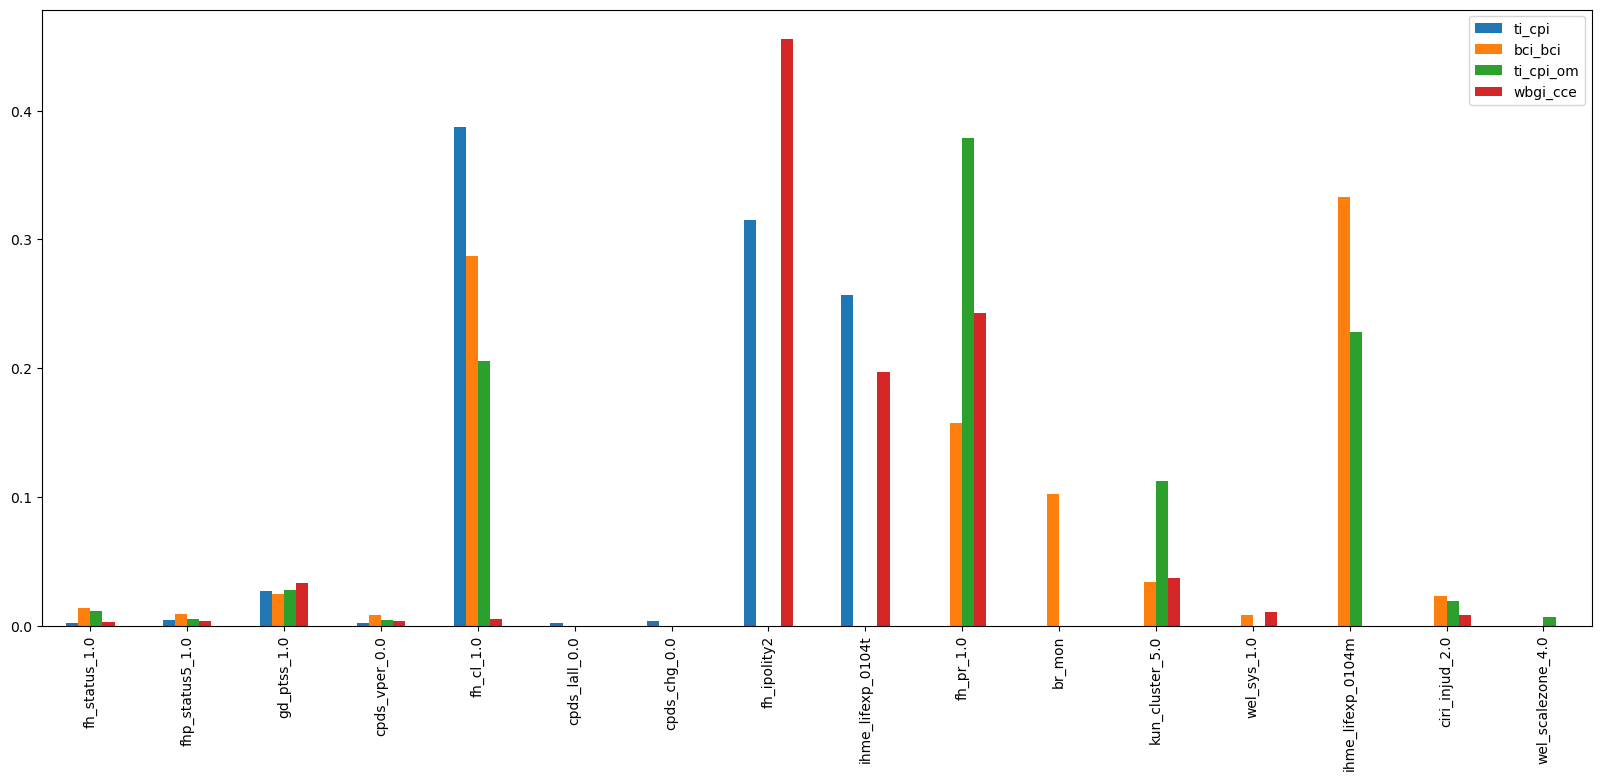

In [56]:
rf_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.635941,9.499529
bci_bci,0.42795,9.917969
ti_cpi_om,0.674722,0.990093
wbgi_cce,0.638329,0.504957


feature importance


,cpds_govlr_nan,cpds_lpen_nan,br_mon,cpds_chg_nan,kun_cluster_5.0,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,wel_sys_1.0,...,ihme_lifexp_0104f,fh_pr_1.0,fh_status_1.0,cpds_lpen_0.0,gd_ptss_1.0,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan
ti_cpi,0.000165,0.000093,0.048914,0.00019,0.0,0.000217,0.000215,0.001916,0.000101,0.000377,...,0.032453,0.162663,0.000913,0.000457,0.008821,0.000282,0.000264,0.035866,0.060275,0.00014
bci_bci,0.000189,0.000359,0.094201,0.00034,0.031447,0.000337,0.00164,0.00218,0.000333,0.006679,...,0.037145,0.005308,0.001458,0.001061,0.013266,0.000375,0.000277,0.052913,0.056899,0.000409
ti_cpi_om,0.000127,0.000148,0.039404,0.000148,0.10015,0.000104,0.000075,0.001287,0.000078,0.057758,...,0.024989,0.007357,0.005328,0.000079,0.002757,0.000072,0.000206,0.048781,0.064757,0.000062
wbgi_cce,0.000058,0.000106,0.048696,0.000128,0.032637,0.000109,0.000624,0.001284,0.000052,0.012482,...,0.023006,0.24248,0.002483,0.00032,0.009015,0.000084,0.000071,0.030023,0.039466,0.000084



feature importance rank


,cpds_govlr_nan,cpds_lpen_nan,br_mon,cpds_chg_nan,kun_cluster_5.0,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,wel_sys_1.0,...,ihme_lifexp_0104f,fh_pr_1.0,fh_status_1.0,cpds_lpen_0.0,gd_ptss_1.0,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan
ti_cpi,25,32,6,24,<NA>,22,23,12,31,17,...,10,2,14,16,11,19,20,8,5,27
bci_bci,34,28,2,29,9,30,18,17,31,13,...,8,14,20,21,11,27,32,5,4,26
ti_cpi_om,28,27,6,26,2,29,33,19,32,4,...,10,12,13,31,18,34,22,5,3,35
wbgi_cce,34,28,4,26,7,27,21,18,35,11,...,10,2,16,23,12,31,32,8,5,30


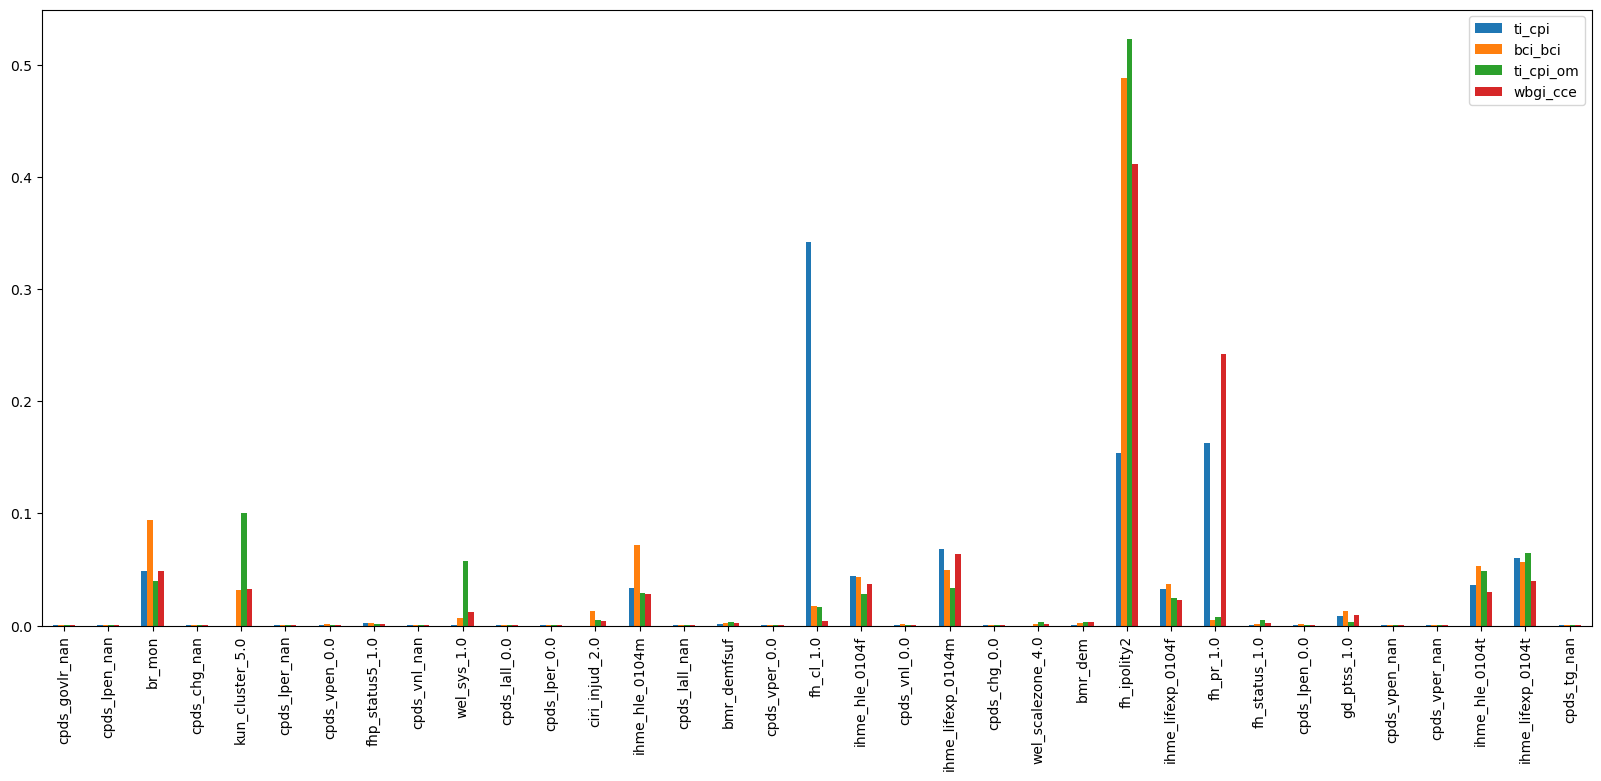

In [57]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.593483,10.038187
bci_bci,0.363788,10.459399
ti_cpi_om,0.606302,1.089257
wbgi_cce,0.627294,0.512602


feature importance


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,0.060851,0.085056,0.009028,0.015182,0.829883
bci_bci,0.010893,0.157135,0.024159,0.021976,0.785836
ti_cpi_om,0.039683,0.123368,0.017213,0.036525,0.783212
wbgi_cce,0.066466,0.115647,0.009117,0.023107,0.785663



feature importance rank


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,3,2,5,4,1
bci_bci,5,2,3,4,1
ti_cpi_om,3,2,5,4,1
wbgi_cce,3,2,5,4,1


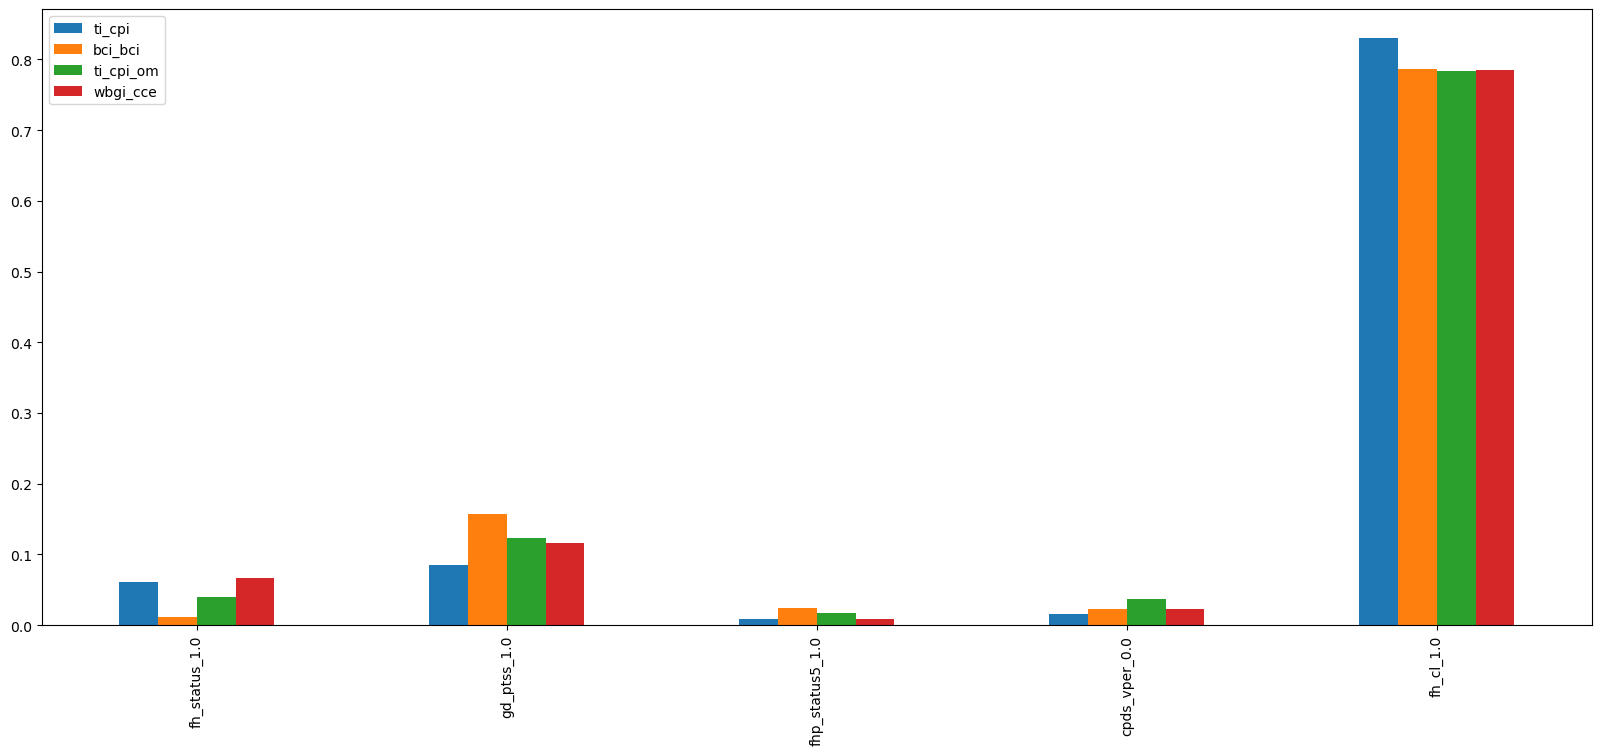

In [58]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [7]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()
    print()
    
    return rf_bf


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

In [94]:
rf_gridsearch_info_script(selected_features_dict)

KeyboardInterrupt: 

scores


,r2,rmse
ti_cpi,0.609208,9.842129
bci_bci,0.39972,10.159745
ti_cpi_om,0.647446,1.03077
wbgi_cce,0.648595,0.497739


feature importance


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,0.098992,0.207542,0.056767,0.154127,0.482572
bci_bci,0.009889,0.273519,0.063108,0.160924,0.49256
ti_cpi_om,0.04547,0.194402,0.036225,0.24142,0.482483
wbgi_cce,0.097707,0.181302,0.025416,0.226099,0.469477



feature importance rank


,fh_status_1.0,gd_ptss_1.0,fhp_status5_1.0,cpds_vper_0.0,fh_cl_1.0
ti_cpi,4,2,5,3,1
bci_bci,5,2,4,3,1
ti_cpi_om,4,3,5,2,1
wbgi_cce,4,3,5,2,1


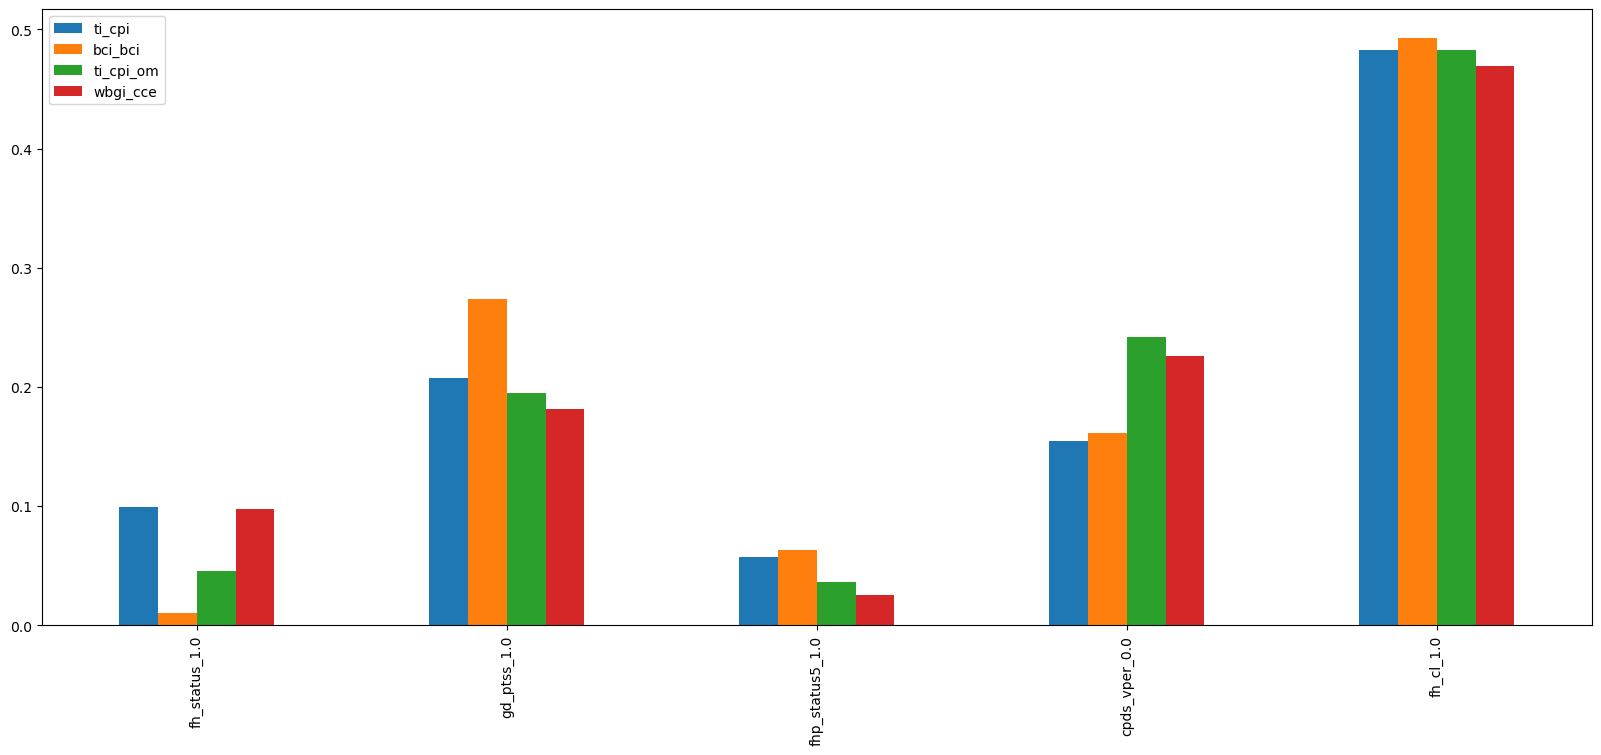

In [63]:
rf_gridsearch_info_script(selected_features_intersection)

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.

scores


,r2,rmse
ti_cpi,0.68902,8.779755
bci_bci,0.52581,9.029883
ti_cpi_om,0.771018,0.830709
wbgi_cce,0.745082,0.423934


feature importance


,br_mon,fh_pr_1.0,cpds_lall_0.0,cpds_chg_0.0,ihme_lifexp_0104t,kun_cluster_5.0,fh_ipolity2,cpds_vper_0.0,fh_status_1.0,ihme_lifexp_0104m,wel_sys_1.0,fhp_status5_1.0,gd_ptss_1.0,wel_scalezone_4.0,fh_cl_1.0,ciri_injud_2.0
ti_cpi,0.058892,0.180801,0.039281,0.00487,0.130656,0.0,0.235153,0.029636,0.028804,0.099864,0.00133,0.010725,0.059827,0.0,0.120161,0.0
bci_bci,0.093258,0.102481,0.018889,0.001809,0.132953,0.026739,0.268113,0.029281,0.005197,0.125365,0.015106,0.017925,0.059484,0.004771,0.084343,0.014286
ti_cpi_om,0.033623,0.077894,0.01706,0.000687,0.111591,0.101641,0.272061,0.01764,0.005135,0.077788,0.127074,0.002053,0.022006,0.008235,0.085884,0.039629
wbgi_cce,0.038116,0.185161,0.034653,0.000334,0.10443,0.021118,0.28479,0.059198,0.025528,0.082411,0.019176,0.008052,0.035403,0.001716,0.091045,0.008869



feature importance rank


,br_mon,fh_pr_1.0,cpds_lall_0.0,cpds_chg_0.0,ihme_lifexp_0104t,kun_cluster_5.0,fh_ipolity2,cpds_vper_0.0,fh_status_1.0,ihme_lifexp_0104m,wel_sys_1.0,fhp_status5_1.0,gd_ptss_1.0,wel_scalezone_4.0,fh_cl_1.0,ciri_injud_2.0
ti_cpi,7,2,8,12,3,<NA>,1,9,10,5,13,11,6,<NA>,4,<NA>
bci_bci,5,4,10,16,2,9,1,8,14,3,12,11,7,15,6,13
ti_cpi_om,9,6,12,16,3,4,1,11,14,7,2,15,10,13,5,8
wbgi_cce,7,2,9,16,3,11,1,6,10,5,12,14,8,15,4,13


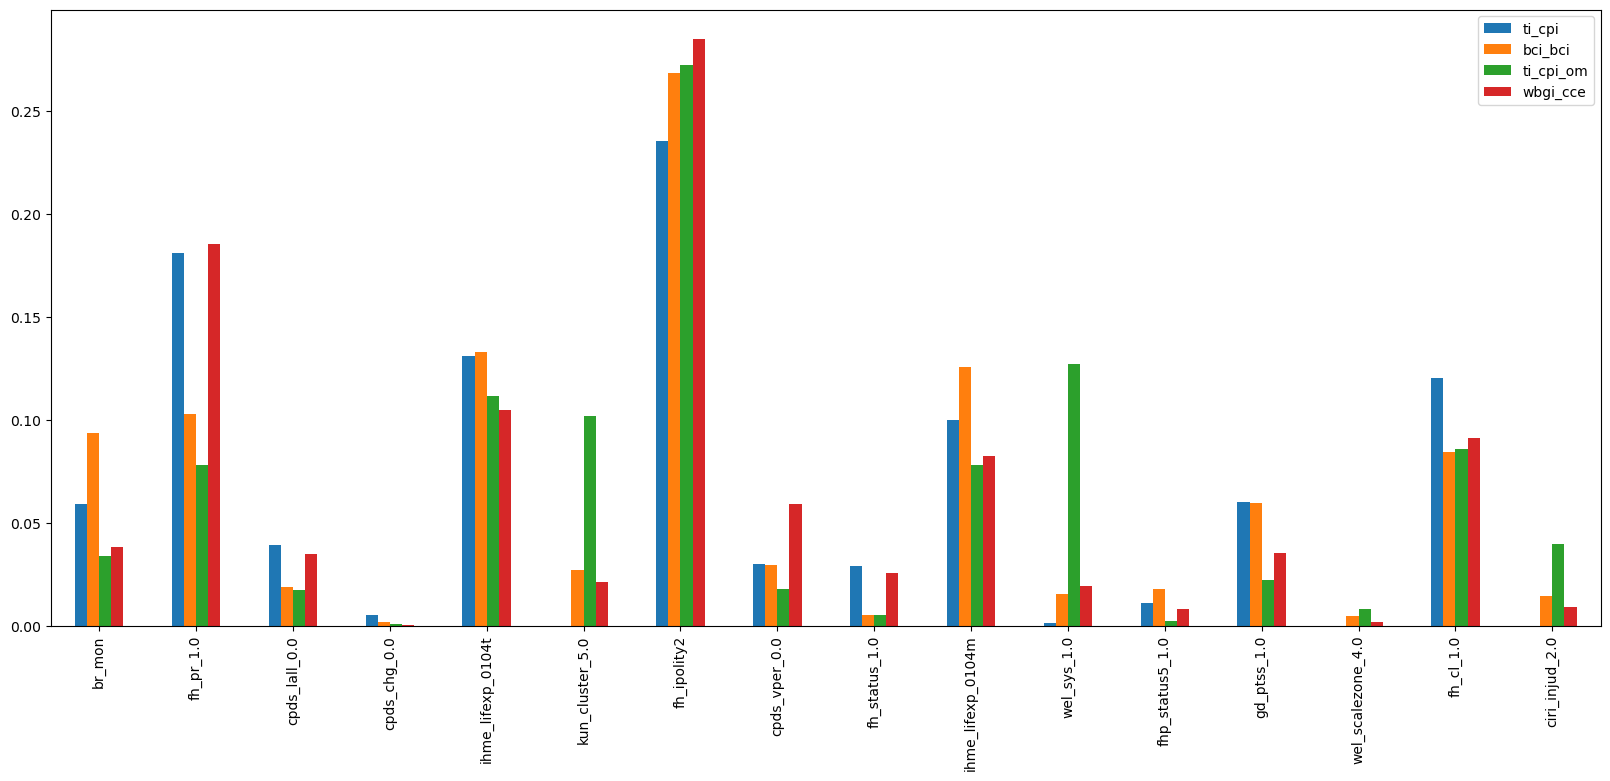

In [8]:
rf_bf = rf_gridsearch_info_script(selected_features_union)

scores


,r2,rmse
ti_cpi,0.702483,8.587608
bci_bci,0.47689,9.484236
ti_cpi_om,0.717838,0.922142
wbgi_cce,0.726693,0.438958


feature importance


,cpds_govlr_nan,cpds_lpen_nan,cpds_chg_nan,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,cpds_lall_0.0,cpds_lper_0.0,ihme_hle_0104m,...,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan,br_mon,kun_cluster_5.0,wel_sys_1.0,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,0.017306,0.00611,0.002156,0.006538,0.002752,0.01168,0.000507,0.016422,0.005285,0.051919,...,0.010542,0.005716,0.05357,0.083069,0.010233,NaN,NaN,NaN,NaN,NaN
bci_bci,0.003072,0.002606,0.000786,0.005226,0.017291,0.007484,0.001744,0.021722,0.021027,0.084166,...,0.005562,0.006666,0.087728,0.085548,0.002794,0.054217,0.021104,0.01049,0.010056,NaN
ti_cpi_om,0.002058,0.003167,0.011484,0.001294,0.003438,0.0074,0.001314,0.032963,0.009434,0.042406,...,0.000346,0.00078,0.07685,0.069905,0.011447,NaN,0.072275,0.086354,0.059244,0.006188
wbgi_cce,0.007405,0.005694,0.011826,0.01086,0.003186,0.009716,0.016164,0.029997,0.054674,0.043797,...,0.005343,0.000732,0.04998,0.070548,0.01638,NaN,0.016517,0.013749,0.00912,NaN



feature importance rank


,cpds_govlr_nan,cpds_lpen_nan,cpds_chg_nan,cpds_lper_nan,cpds_vpen_0.0,fhp_status5_1.0,cpds_vnl_nan,cpds_lall_0.0,cpds_lper_0.0,ihme_hle_0104m,...,cpds_vpen_nan,cpds_vper_nan,ihme_hle_0104t,ihme_lifexp_0104t,cpds_tg_nan,br_mon,kun_cluster_5.0,wel_sys_1.0,ciri_injud_2.0,wel_scalezone_4.0
ti_cpi,12,22,28,21,27,15,30,13,25,10,...,17,23,8,6,18,<NA>,<NA>,<NA>,<NA>,<NA>
bci_bci,25,28,30,24,15,19,29,11,13,7,...,23,21,4,5,27,9,12,17,18,<NA>
ti_cpi_om,26,25,16,28,24,19,27,13,18,10,...,30,29,4,7,17,<NA>,6,3,9,21
wbgi_cce,24,26,20,21,29,22,17,12,7,10,...,27,30,8,5,16,<NA>,15,18,23,<NA>


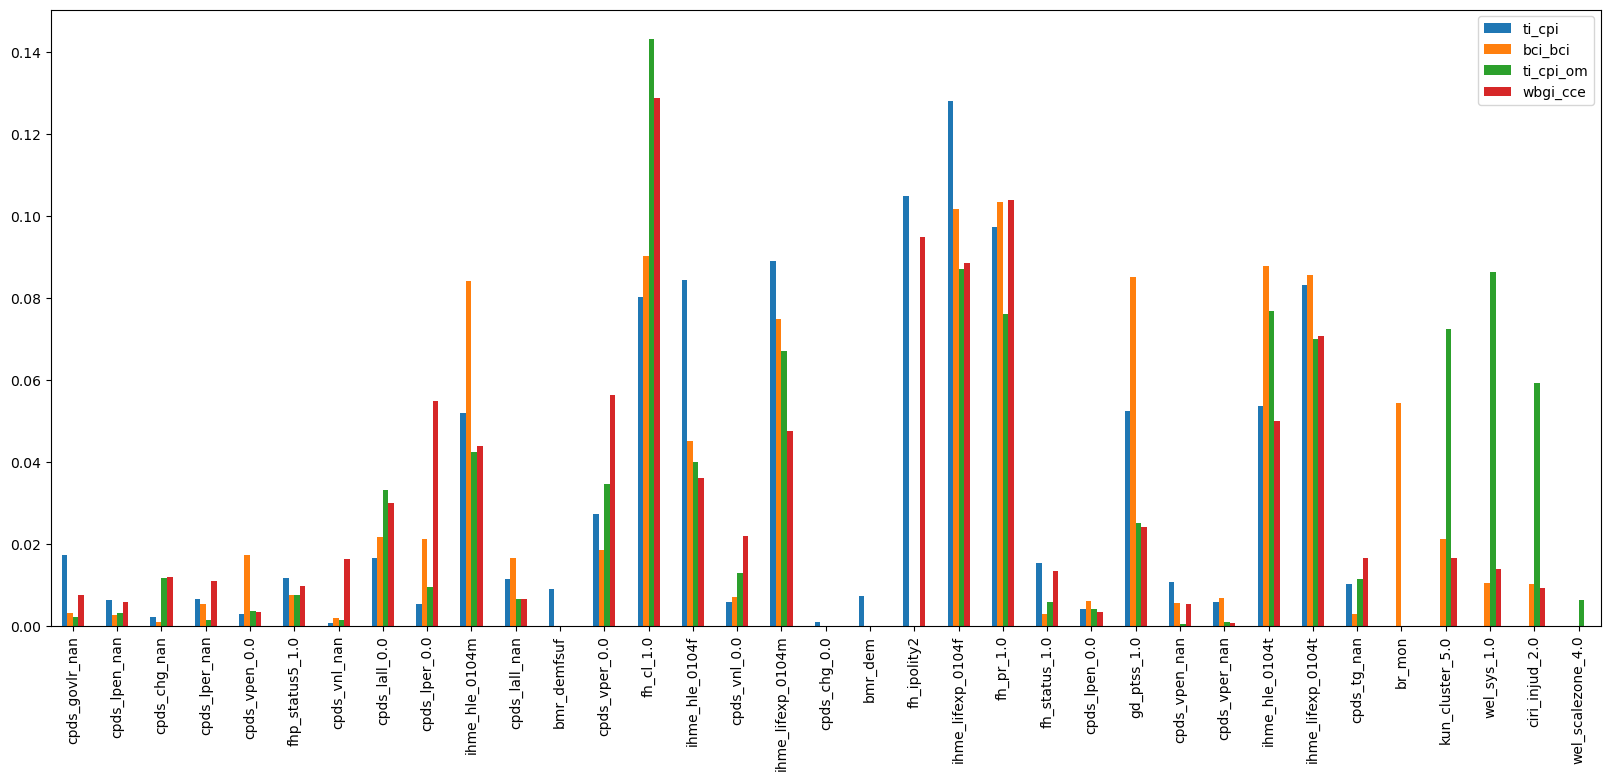

In [65]:
rf_gridsearch_info_script(best_features_dict)

## Evaluation

In [113]:
import pickle
f = open('pickle/rf_grid_selected_features_union.obj', 'rb')
rf_bf_new = pickle.load(f)
f.close()

In [114]:
threshold = 0.3
relative_errs = get_rel_err_df(rf_bf_new, df, corr_cols, threshold).copy()
relative_errs_per_country_full = get_rel_err_df_stats(relative_errs).copy()

In [115]:
relative_errs = relative_errs.dropna(subset='rel_err')

In [116]:
q_dict = {}
for corr_id in relative_errs.corr_id.unique():
    q_dict[corr_id] = relative_errs[relative_errs.corr_id == corr_id].rel_err.quantile(q=0.75)
q_dict

{'ti_cpi': 0.26149913488637044,
 'bci_bci': 0.20900302649461783,
 'ti_cpi_om': 0.2762552053944278,
 'wbgi_cce': 0.9729932263201228}

In [117]:
relative_errs.groupby('corr_id').rel_err.agg(['count', 'min', 'max', 'mean'])

,count,min,max,mean
corr_id,,,,
bci_bci,586,0.000035,0.710219,0.142266
ti_cpi,208,0.003868,1.865241,0.213825
ti_cpi_om,378,0.000139,1.540204,0.218229
wbgi_cce,586,0.000766,29.210147,1.023209


In [118]:
px.box(relative_errs, y="rel_err", x="corr_id", title='Relative error distribution by corruption index')

In [119]:
relative_errs['range'] = 'normal'
for corr_id in relative_errs.corr_id.unique():
    relative_errs.loc[(relative_errs.corr_id == corr_id) & (relative_errs.rel_err > q_dict[corr_id]), 'range'] = 'outlier'

# Evaluation

### By region

There is no big difference between performance of models across regions. ti_cpi models have slightly more problems with predicting Oceania. Oceania has smaller range or relative errors because it contains only 1 country: Papua New Guinea.
We can also see that wbgi_cce has much larger number of outliers in comparison to other models.

In [246]:
for corr_id in ['ti_cpi', 'ti_cpi_om', 'bci_bci', 'wbgi_cce']:
    fig = px.box(relative_errs[relative_errs.corr_id == corr_id], 
                    y="rel_err", 
                    x="region", 
                    title=f'Relative error distribution by region for {corr_id}', 
                    hover_data=[corr_id, 'year', 'cname'])
    fig.update_layout(
        width=700,
        height=400,
        margin={'t': 35, 'b': 35}
    )

    fig.show()

### By sub-region
#### Africa
We can see that ti_cpi model performs much worse for Northern Africa than for Sub-Saharan Africa, whereas for wbgi_cce it's the opposite. The countries with the very big outliers all belong to the Sub-Saharan Africa, but they are not the same across different indices: ti_cpi and ti_cpi_om models have problems when predicting values for Somalia, but bci_bci model has problems with Botswana and wbgi_cce model has problems with predicting values for Ghana and South Africa. These problems persist over multiple years for each country, but not across indices, hence with high probability the problem lies in the prediction models and not in the mismatch between countrie's characteristics and position on the index.
#### Europe
Big relative error range shows that all models have more difficulties predicting values for countries from Eastern Europe. For bci_bci, the relative error for Eastern Europe is significantly worse than for other European regions. Since this trend persist over all the indeces, one could say that there is a suspicious mismatch between predictors and the estimated corruption index.

For other regions different models perform slightly differently (i.e., ti_cpi and ti_cpi_om models have more problems with Southern Europe, whereas bci_bci model has difficulties with Northern Europe), but since they don't hold across the indices they are less interesting for us.

Interestingly multiple models (ti_cpi_om, wgbi_cce) have Latvia from the beginning of the 2000s as an outlier, but the years are different.
#### Asia
Different models have slightly different performance for countries of each region of Asia, but all in all there are no major differences in the performance of the models and interesting common connections which would hold across the indices.
#### Oceania
As were said previously, Oceania contains only 1 country (Papua New Guinea) and only 1 sub-region (Pacific Islands) in the test set, so it is not possible to make any comparisons.
#### Americas
Since North America is extremely small and contains only 2 countries in total, it is not represented in the test dataset.

From the big range of relative errors we can see that bci_bci model has much more difficulties predicting values for countries from Latin America and the Caribbean than countries from other sub-regions. For other models the results are comparable. The performance of other models are comparable for this region. The outlier countries are same within models, but differ across different models, so there are also no interesting connections here.


In [251]:
for corr_id in ['ti_cpi', 'ti_cpi_om', 'bci_bci', 'wbgi_cce']:
    fig = px.box(relative_errs[relative_errs.corr_id == corr_id], 
                    x="rel_err", 
                    y="sub-region", 
                    color='region',
                    title=f'Relative error distribution by sub-region for {corr_id}', 
                    hover_data=[corr_id, 'year', 'cname'])
    fig.update_layout(
        width=1000,
        height=500,
        margin={'t': 35, 'b': 35}
    )

    fig.show()

In [120]:
plot_dicts = {}
for corr_id in relative_errs.corr_id.unique():
    plot_dicts[corr_id] = get_plots(relative_errs, q_dict, corr_id)

### Regions

In [109]:
import plotly.subplots as sp

In [209]:
for corr_id in ['ti_cpi', 'ti_cpi_om', 'bci_bci', 'wbgi_cce']:
    plot_dicts[corr_id]['normal_dist_region'].show()

## By region
### Full range
- 

### Normal range
- no big differences across regions & indices
- Oceania predictions worse for all indices: logical, because Oceania is the least represented region
- Predictions for wbgi_cce worse, agrees with the box plot, but the distribution of errors is similar within first 3 quantiles range

### Outlier range
- ti_cpi worst prediction for Africa
- otherwise no big differences across regions, all regions present & prediction errors more or less same
- surprisingly, wbgi_cee and bci_bci don't have oceania outliers, all oceania relative errors within normal range

## By sub-region
### Normal range
#### Europe
- bci_bci has problems with predicting Eastern Europe values, although it's not underrepresented
- wbgi_cce has problems with predicting Southern Europe values
- ti_cpi both predict Eastern and Southern Europe values worse
#### Asia
- ti_cpi performs worse for South-eastern and Western Asia
- ti_cpi_om performs worse for Souther-eastern Asia
- bci_bci performs worse for Southern Asia
#### Africa
- Only one region in Africa, predicted more or less same across indices
#### America
- Only latin america in test dataset bc only 2 countries in north america.
- bci_bci prediction slightly better then by other indices
#### Oceania
- only 1 sub-region, no significant differences btw indices

### Outlier range
#### Europe
- eastern eaurope outliers in each index, westen, northern, southern not present in all indices
- wbgi_cce & ti_cpi_om, bci_bci worst prediction for northern europe
- ti_cpi only has eastern & southern europs
#### Asia
- wbgi_cce has biggest outliers in western asia
- ti_cpi_om have biggest outliers in southern asia
#### Africa
- All northern africas are in the outlier range, so model totally fails for northern africas
- but sub-saharan outliers are worse than northern africas ones 
#### America
#### Oceania
- bci_bci anf wbgi_cce have no Oceania outliers

### Main points to write down:
#### For regions:
- wbgi_cce & bci_bci don't have oceania outliers, all oceania countries are in the normal range
    - check: are ti_cpi & ti_cpi_om have the same countries in outliers?
    - answer: the same country, Papua New Guinea
- but all in all, no big differences in relative errors across regions & indices

#### For sub-regions:
- southern and eastern europe are the worst predicted regions within normal range
- eastern europe is in outliers for each index
    - check: are this the same countries?
    - yes, Belarus and Czechia
- absolute worst outliers for all indices except ti_cpi has northern europe
    - check: are this the same countries?
    - no, ti_cpi_om & wbgi_cce hate Latvia (wbgi_cce hates Latvia more)
    - bci_bci has a big problem with norway
- northern africa is only present in outliers, so the model has problem with predicting northern africa
- worst outliers in africa region are for sub-sahara africa
    - check: are this the same countries?
    - yes and no: Botswana, Seychelles are hated by all indices
    - other countries differ

In [ ]:
relative_errs[relative_errs.region == 'Oceania'].

In [177]:
relative_errs['sub-region'].unique()

array(['Southern Europe', 'Western Asia', 'Western Europe',
       'Sub-Saharan Africa', 'Eastern Europe', 'Eastern Asia',
       'Latin America and the Caribbean', 'South-eastern Asia',
       'Northern Europe', 'Northern Africa', 'Southern Asia',
       'Pacific Islands', 'Central Asia'], dtype=object)

In [169]:
relative_errs['wbgi_cce'] = df.loc[relative_errs.original_id, 'wbgi_cce'].values
relative_errs['ti_cpi'] = df.loc[relative_errs.original_id, 'ti_cpi'].values
relative_errs['ti_cpi_om'] = df.loc[relative_errs.original_id, 'ti_cpi_om'].values
relative_errs['bci_bci'] = df.loc[relative_errs.original_id, 'bci_bci'].values

In [188]:
corr_id = 'bci_bci'

In [171]:
px.scatter(relative_errs, x='bci_bci', y='rel_err', color='region', hover_data=['sub-region', 'cname', 'year'])

In [194]:
corr_id_min = relative_errs[relative_errs.corr_id == corr_id][corr_id].min()
corr_id_max = relative_errs[relative_errs.corr_id == corr_id][corr_id].max()

In [203]:
fig1 = px.line(x=[corr_id_min, corr_id_max], y=[q_dict[corr_id], q_dict[corr_id]], color_discrete_sequence=['black'])
fig1.update_traces(line=dict(color = 'rgba(50,50,50,0.2)'))

fig2 = px.scatter(relative_errs, x='bci_bci', y='rel_err', color='region', hover_data=['sub-region', 'cname', 'year'])

fig3 = go.Figure(data=fig2.data + fig1.data)
fig3.show()

In [137]:
region_count = pd.DataFrame(df.groupby('region').cname.count()).reset_index(drop=False)
region_count.columns = ['region', 'num of samples']

region_country_count = pd.DataFrame(df.groupby('region').cname.nunique()).reset_index(drop=False)
region_country_count.columns = ['region', 'num of countries']

region_info_df = region_count.merge(region_country_count, on='region')
region_info_df = region_info_df.melt(id_vars=['region'], value_vars=['num of samples', 'num of countries'])

Text(0.5, 1.0, 'Regions by number of countries')

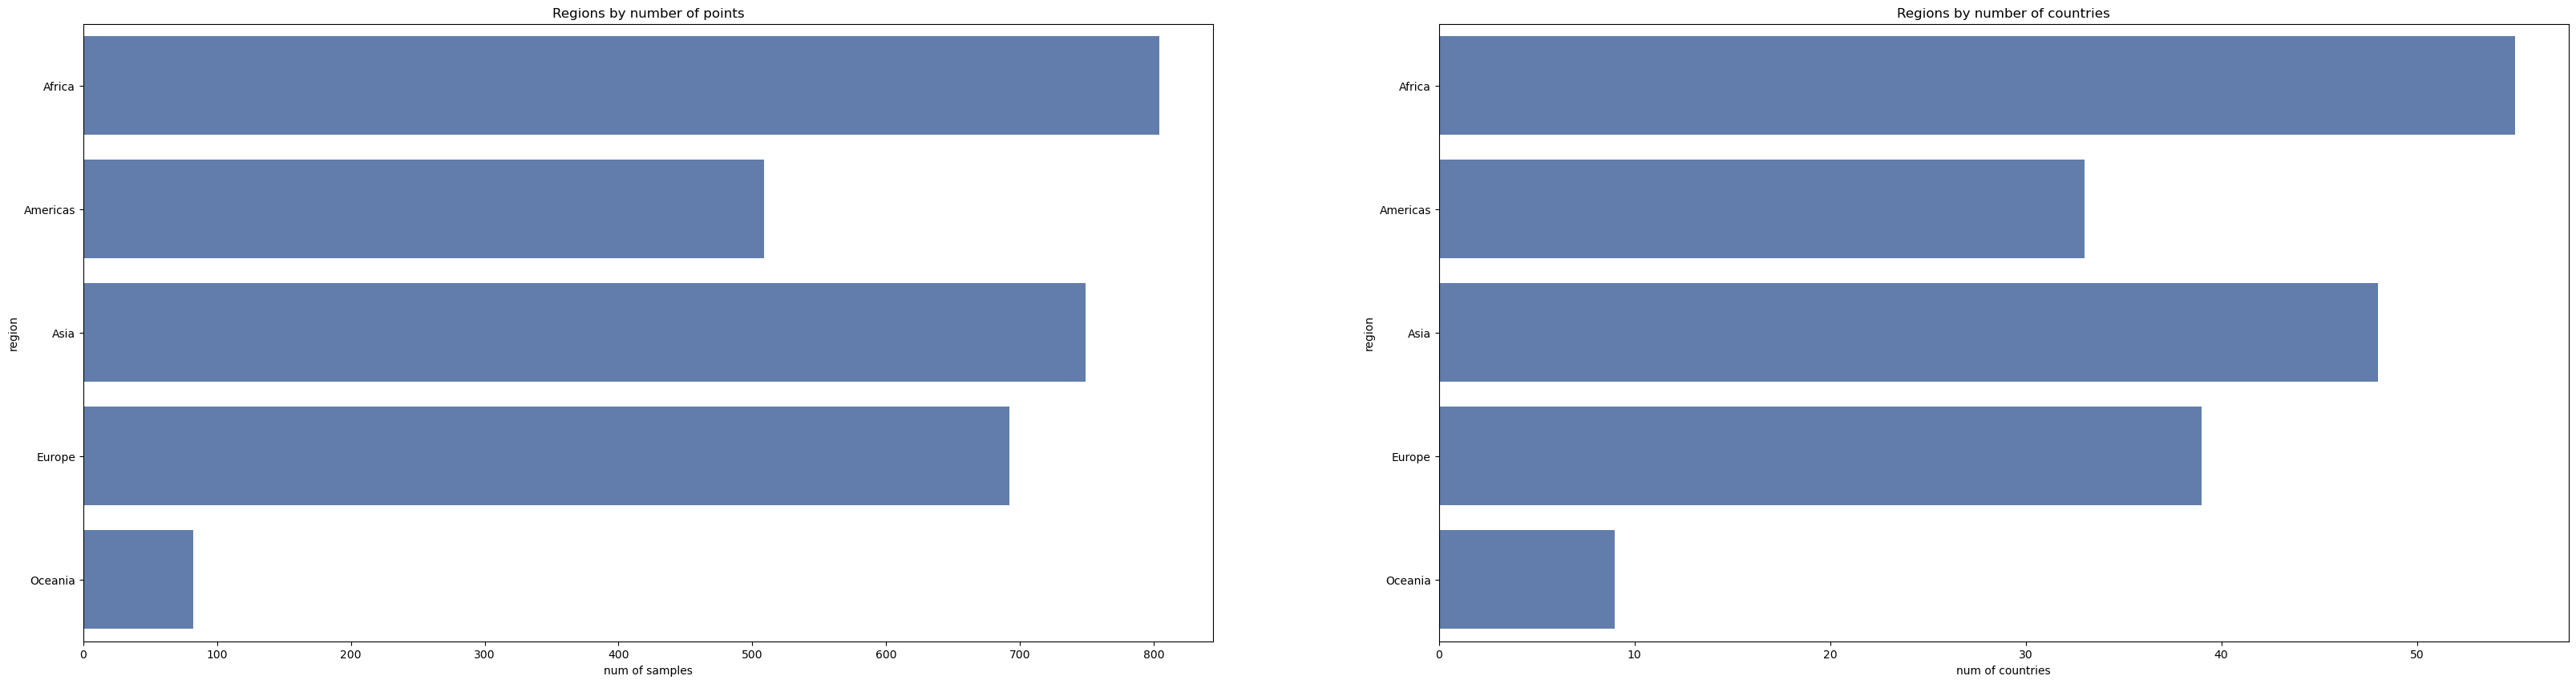

In [138]:
_, ax = plt.subplots(1, 2, figsize=(40, 10))
sns.barplot(data=region_count, y='region', x='num of samples', color='#567ab8', ax=ax[0])
ax[0].set_title('Regions by number of points')
sns.barplot(data=region_country_count, y='region', x='num of countries', color='#567ab8', ax=ax[1])
ax[1].set_title('Regions by number of countries')

In [143]:
region_count = pd.DataFrame(df.groupby('sub-region').cname.count()).reset_index(drop=False)
region_count.columns = ['sub-region', 'num of samples']

region_country_count = pd.DataFrame(df.groupby('sub-region').cname.nunique()).reset_index(drop=False)
region_country_count.columns = ['sub-region', 'num of countries']

region_info_df = region_count.merge(region_country_count, on='sub-region')
region_info_df = region_info_df.melt(id_vars=['sub-region'], value_vars=['num of samples', 'num of countries'])

Text(0.5, 1.0, 'Sub-regions by number of countries')

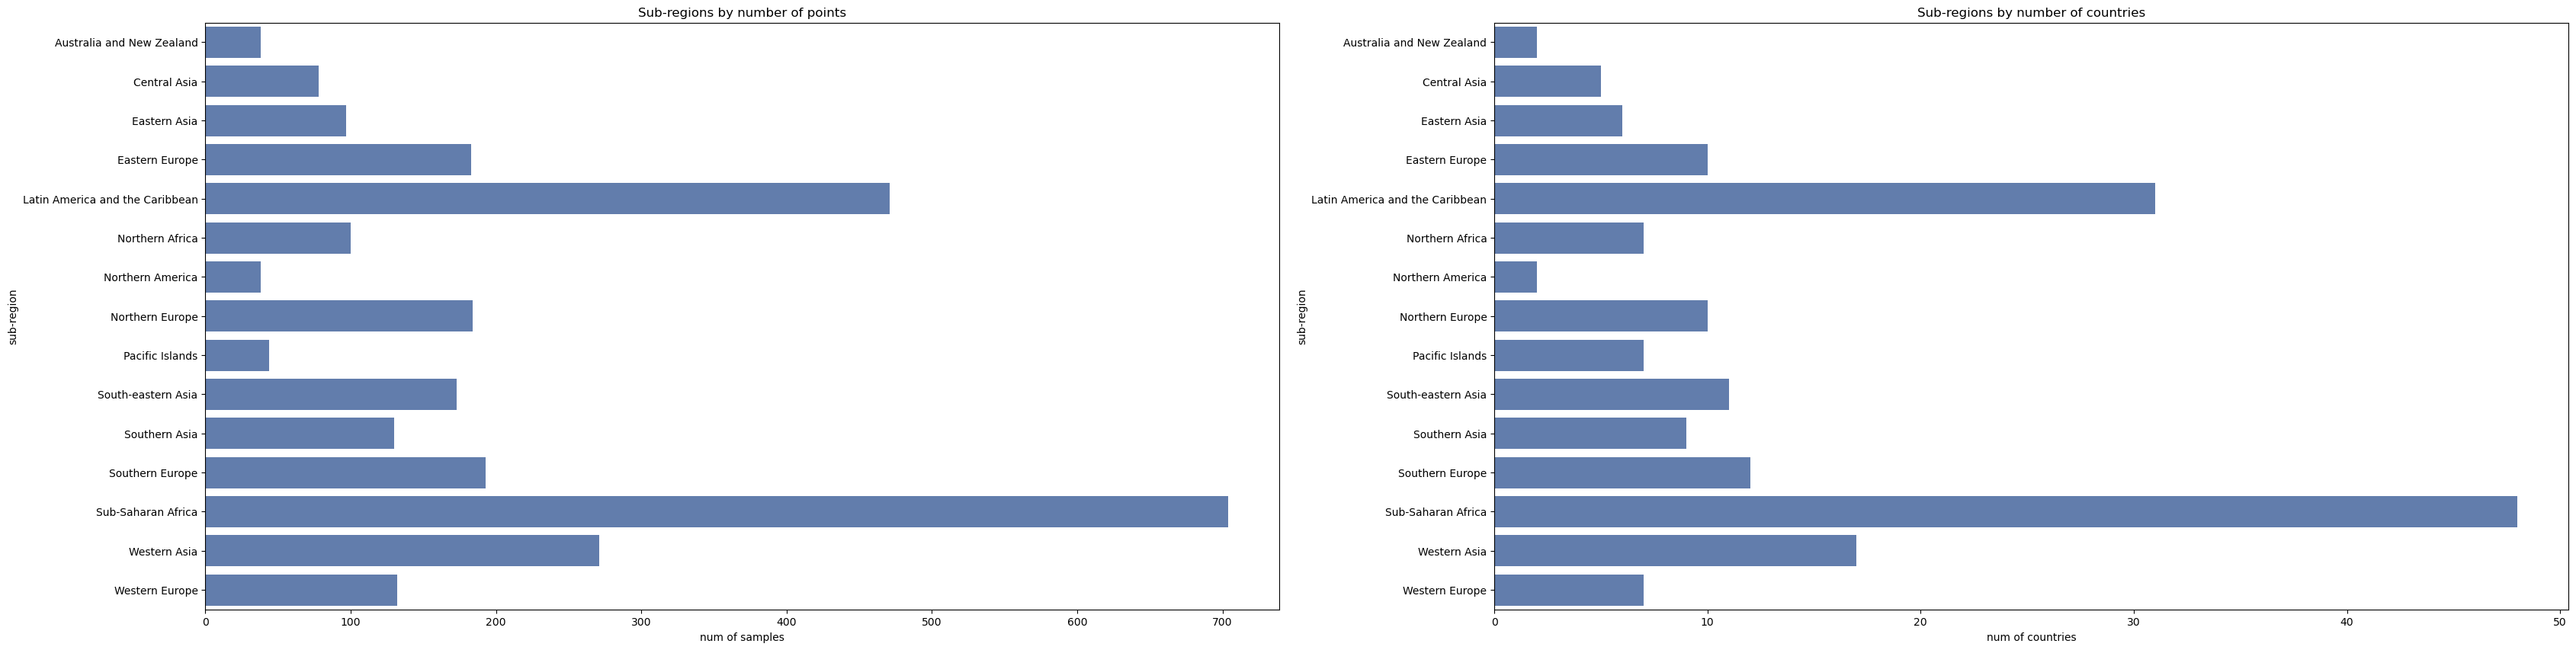

In [144]:
_, ax = plt.subplots(1, 2, figsize=(40, 10))
sns.barplot(data=region_count, y='sub-region', x='num of samples', color='#567ab8', ax=ax[0])
ax[0].set_title('Sub-regions by number of points')
sns.barplot(data=region_country_count, y='sub-region', x='num of countries', color='#567ab8', ax=ax[1])
ax[1].set_title('Sub-regions by number of countries')